# Stock Market Regression this time with a Transformer Model

In [716]:
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [717]:
import pandas as pd
spy = pd.read_csv('newdata/SPY.csv')
print(spy.head())

dataDate = spy.loc[:, 'ticker'].values
dataLastPrice = spy.loc[:, 'SPY US Equity'].values

# pop junk out of here
dataDate = dataDate[2:]
dataLP = dataLastPrice[2:].astype(float)

       ticker SPY US Equity SPY US Equity.1 SPY US Equity.2 SPY US Equity.3  \
0       field       PX_LAST         PX_OPEN    MOV_AVG_200D      MOV_AVG_5D   
1        date           NaN             NaN             NaN             NaN   
2  2000-01-03      145.4375          148.25        134.9281        146.3906   
3  2000-01-04        139.75        143.5313        134.9771        145.1031   
4  2000-01-05         140.0        139.9375        135.0462        143.7406   

  SPY US Equity.4 Close Tomorrow  
0     MOV_AVG_50D            NaN  
1             NaN            NaN  
2        140.2524         139.75  
3        140.4455          140.0  
4        140.6568         137.75  


In [718]:
def prepare_data_x(x, window_size):
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, 20)
    data_y = prepare_data_y(normalized_data_close_price, 20)

    # split dataset

    split_index_train_val = int(data_y.shape[0]*0.6)
    split_index_val_test = int(data_y.shape[0]*0.6) + int(data_y.shape[0]*0.2)
    data_x_train = data_x[:split_index_train_val]
    data_x_val = data_x[split_index_train_val:split_index_val_test]
    data_x_test = data_x[split_index_val_test:]

    data_y_train = data_y[:split_index_train_val]
    data_y_val = data_y[split_index_train_val:split_index_val_test]
    data_y_test = data_y[split_index_val_test:]

    return split_index_train_val, data_x_train, data_y_train, data_x_val, data_y_val, data_x_test, data_y_test, data_x_unseen


In [719]:
'''
def get_src_trg(sequence, enc_seq_len, target_seq_len):

        src = sequence[:enc_seq_len] 

        trg = sequence[enc_seq_len-1:len(sequence)-1] 


        if len(trg.shape) == 1:

            trg = trg.unsqueeze(-1)

        trg_y = sequence[-target_seq_len:]

        return src, trg, trg_y.squeeze(-1) # change size from [batch_size, target_seq_len, num_features] to [batch_size, target_seq_len] 
'''

def get_src_trg(
        sequence: torch.Tensor, 
        enc_seq_len: int, 
        target_seq_len: int
        ) -> ([torch.tensor, torch.tensor, torch.tensor]):

        """
        Generate the src (encoder input), trg (decoder input) and trg_y (the target)
        sequences from a sequence. 
        Args:
            sequence: tensor, a 1D tensor of length n where 
                    n = encoder input length + target sequence length  
            enc_seq_len: int, the desired length of the input to the transformer encoder
            target_seq_len: int, the desired length of the target sequence (the 
                            one against which the model output is compared)
        Return: 
            src: tensor, 1D, used as input to the transformer model
            trg: tensor, 1D, used as input to the transformer model
            trg_y: tensor, 1D, the target sequence against which the model output
                is compared when computing loss. 
        
        """
        #print("Called dataset.TransformerDataset.get_src_trg")
        assert len(sequence) == enc_seq_len + target_seq_len, "Sequence length does not equal (input length + target length)"
        
        #print("From data.TransformerDataset.get_src_trg: sequence shape: {}".format(sequence.shape))

        # encoder input
        src = sequence[:enc_seq_len] 
        
        # decoder input. As per the paper, it must have the same dimension as the 
        # target sequence, and it must contain the last value of src, and all
        # values of trg_y except the last (i.e. it must be shifted right by 1)
        trg = sequence[enc_seq_len:len(sequence)]

        #print("From data.TransformerDataset.get_src_trg: trg shape before slice: {}".format(trg.shape))

        #trg = trg[:, 0]

        #print("From data.TransformerDataset.get_src_trg: trg shape after slice: {}".format(trg.shape))

        if len(trg.shape) == 1:

            trg = trg.unsqueeze(-1)

            #print("From data.TransformerDataset.get_src_trg: trg shape after unsqueeze: {}".format(trg.shape))

        
        assert len(trg) == target_seq_len, "Length of trg does not match target sequence length"

        # The target sequence against which the model output will be compared to compute loss
        trg_y = sequence[-target_seq_len:]

        #print("From data.TransformerDataset.get_src_trg: trg_y shape before slice: {}".format(trg_y.shape))

        # We only want trg_y to consist of the target variable not any potential exogenous variables
        #trg_y = trg_y[:, 0]

        #print("From data.TransformerDataset.get_src_trg: trg_y shape after slice: {}".format(trg_y.shape))

        assert len(trg_y) == target_seq_len, "Length of trg_y does not match target sequence length"

        return src, trg, trg_y.squeeze(-1) # change size from [batch_size, target_seq_len, num_features] to [batch_size, target_seq_len] 

In [730]:

def generate_square_subsequent_mask(dim1: int, dim2: int) -> Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Source:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    Args:
        dim1: int, for both src and tgt masking, this must be target sequence
              length
        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 
    Return:
        A Tensor of shape [dim1, dim2]
    """

    tensor = [0.] * dim2
    tensor[dim1-1] = 1.
    return torch.tensor(tensor).reshape(1, -1)
    #return torch.triu(torch.ones(dim1, dim2), diagonal=1)

# Input length
enc_seq_len = 20

# Output length
output_sequence_length = 1

# We can create these now bc they dont change with the batch
tgt_mask = generate_square_subsequent_mask(
    dim1=output_sequence_length,
    dim2=output_sequence_length
   )

src_mask = generate_square_subsequent_mask(
    dim1=output_sequence_length,
    dim2=enc_seq_len
    )

src_mask = src_mask.flip(dims=(1,))
print(src_mask)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1.]])


### The Transformer Model

In [745]:
class TransformerDataset(Dataset):
    def __init__(self, x):
        self.len = len(x)
        
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        src, trg, trg_y = get_src_trg(sequence=torch.FloatTensor(dataLP[idx:idx+21]), enc_seq_len=20, target_seq_len=1)
        return (src, trg, trg_y)

class Transformations():
    def __init__(self):
        self.mu = None
        self.sd = None

    def normalize(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        return (x-self.mu)/self.sd

    def inverseNormalize(self, x):
        return ((x*self.sd) + self.mu)



In [746]:
transformer = Transformations()
normLP = transformer.normalize(dataLP)

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_test, data_y_test, data_x_unseen = prepare_data(dataLP)

dataset_train = TransformerDataset(data_x_train)
dataset_val = TransformerDataset(data_x_val)
dataset_test = TransformerDataset(data_x_test)


### The Transformer Model

In [747]:
class PositionalEncoder(nn.Module):
    """
    The authors of the original transformer paper describe very succinctly what 
    the positional encoding layer does and why it is needed:
    
    "Since our model contains no recurrence and no convolution, in order for the 
    model to make use of the order of the sequence, we must inject some 
    information about the relative or absolute position of the tokens in the 
    sequence." (Vaswani et al, 2017)
    Adapted from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=5000, 
        d_model: int=512,
        batch_first: bool=False
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first

        self.x_dim = 1 if batch_first else 0

        # copy pasted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe = torch.zeros(max_seq_len, 1, d_model)
        
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """

        x = x + self.pe[:x.size(self.x_dim)]

        return self.dropout(x)


In [748]:

class TimeSeriesTransformer(nn.Module):

    """
    This class implements a transformer model that can be used for times series
    forecasting. This time series transformer model is based on the paper by
    Wu et al (2020) [1]. The paper will be referred to as "the paper".
    A detailed description of the code can be found in my article here:
    https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e
    In cases where the paper does not specify what value was used for a specific
    configuration/hyperparameter, this class uses the values from Vaswani et al
    (2017) [2] or from PyTorch source code.
    Unlike the paper, this class assumes that input layers, positional encoding 
    layers and linear mapping layers are separate from the encoder and decoder, 
    i.e. the encoder and decoder only do what is depicted as their sub-layers 
    in the paper. For practical purposes, this assumption does not make a 
    difference - it merely means that the linear and positional encoding layers
    are implemented inside the present class and not inside the 
    Encoder() and Decoder() classes.
    [1] Wu, N., Green, B., Ben, X., O'banion, S. (2020). 
    'Deep Transformer Models for Time Series Forecasting: 
    The Influenza Prevalence Case'. 
    arXiv:2001.08317 [cs, stat] [Preprint]. 
    Available at: http://arxiv.org/abs/2001.08317 (Accessed: 9 March 2022).
    [2] Vaswani, A. et al. (2017) 
    'Attention Is All You Need'.
    arXiv:1706.03762 [cs] [Preprint]. 
    Available at: http://arxiv.org/abs/1706.03762 (Accessed: 9 March 2022).
    """

    def __init__(self, 
        input_size: int,
        dec_seq_len: int,
        batch_first: bool,
        out_seq_len: int=58,
        dim_val: int=512,  
        n_encoder_layers: int=4,
        n_decoder_layers: int=4,
        n_heads: int=8,
        dropout_encoder: float=0.2, 
        dropout_decoder: float=0.2,
        dropout_pos_enc: float=0.1,
        dim_feedforward_encoder: int=2048,
        dim_feedforward_decoder: int=2048,
        num_predicted_features: int=1
        ): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            dim_val: int, aka d_model. All sub-layers in the model produce 
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            n_decoder_layers: int, number of stacked encoder layers in the decoder
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            dropout_decoder: float, the dropout rate of the decoder
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer 
                                     of the encoder
            dim_feedforward_decoder: int, number of neurons in the linear layer 
                                     of the decoder
            num_predicted_features: int, the number of features you want to predict.
                                    Most of the time, this will be 1 because we're
                                    only forecasting FCR-N prices in DK2, but in
                                    we wanted to also predict FCR-D with the same
                                    model, num_predicted_features should be 2.
        """

        super().__init__() 

        self.dec_seq_len = dec_seq_len

        #print("input_size is: {}".format(input_size))
        #print("dim_val is: {}".format(dim_val))

        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )

        self.decoder_input_layer = nn.Linear(
            in_features=num_predicted_features,
            out_features=dim_val
            )  
        
        self.linear_mapping = nn.Linear(
            in_features=dim_val, 
            out_features=num_predicted_features
            )

        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc
            )

        # The encoder layer used in the paper is identical to the one used by
        # Vaswani et al (2017) on which the PyTorch module is based.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=batch_first
            )

        # Stack the encoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerEncoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=batch_first
            )

        # Stack the decoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerDecoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, 
                tgt_mask: Tensor=None) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            src_mask: the mask for the src sequence to prevent the model from 
                      using data points from the target sequence
            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        """

        #print("From model.forward(): Size of src as given to forward(): {}".format(src.size()))
        #print("From model.forward(): tgt size = {}".format(tgt.size()))

        # Pass throguh the input layer right before the encoder
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after input layer: {}".format(src.size()))

        # Pass through the positional encoding layer
        src = self.positional_encoding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after pos_enc layer: {}".format(src.size()))

        # Pass through all the stacked encoder layers in the encoder
        # Masking is only needed in the encoder if input sequences are padded
        # which they are not in this time series use case, because all my
        # input sequences are naturally of the same length. 
        # (https://github.com/huggingface/transformers/issues/4083)
        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
            )
        #print("From model.forward(): Size of src after encoder: {}".format(src.size()))

        # Pass decoder input through decoder input layer
        decoder_output = self.decoder_input_layer(tgt) # src shape: [target sequence length, batch_size, dim_val] regardless of number of input features
        #print("From model.forward(): Size of decoder_output after linear decoder layer: {}".format(decoder_output.size()))

        #if src_mask is not None:
            #print("From model.forward(): Size of src_mask: {}".format(src_mask.size()))
        #if tgt_mask is not None:
            #print("From model.forward(): Size of tgt_mask: {}".format(tgt_mask.size()))

        # Pass throguh decoder - output shape: [batch_size, target seq len, dim_val]
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
            )

        #print("From model.forward(): decoder_output shape after decoder: {}".format(decoder_output.shape))

        # Pass through linear mapping
        decoder_output = self.linear_mapping(decoder_output) # shape [batch_size, target seq len]
        #print("From model.forward(): decoder_output size after linear_mapping = {}".format(decoder_output.size()))

        return decoder_output


In [754]:

## Model parameters
dim_val = 600 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 10 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 5 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 5# Number of times the encoder layer is stacked in the encoder
dec_seq_len = 1 # length of input given to decoder. Can have any integer value.
output_sequence_length = 20 # Length of the target sequence, i.e. how many time steps should your forecast cover
enc_seq_len = 20 # length of input given to encoder. Can have any integer value.
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoder


input_size = 1 # The number of input variables. 1 if univariate forecasting.

model = TimeSeriesTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    batch_first=True,
    #max_seq_len=max_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads)

### Training the Model

In [756]:
batch_size = 16

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

learning_rate = 0.01
sched_step_size = 5
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.1, 0.1), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=sched_step_size, gamma=0.1)

epochs = 100
for epoch in range(epochs):
    model.train()
    losses = []
    val_losses = []
    for idx, (src, trg, trg_y) in enumerate(train_dataloader):
        
        #print(src_mask)
        #print(src.size())
        if len(src) == 16:
            output = model(
                src=src.reshape(16, 20, 1), 
                tgt=trg,
                src_mask=src_mask,
                tgt_mask=tgt_mask
                )
            loss = criterion(output.squeeze(), trg_y.squeeze())
            loss.backward()
            optimizer.step()
            valueLoss = loss.detach().item()/batch_size
            losses.append(valueLoss)

    model.eval()
    for idx, (src, trg, trg_y) in enumerate(val_dataloader):

        if len(src) == 16:
            output = model(
                src=src.reshape(16, 20, 1), 
                tgt=trg,
                src_mask=src_mask,
                tgt_mask=tgt_mask
                )
            out = output.cpu().detach().numpy().squeeze()
            loss = criterion(output.squeeze(), trg_y.squeeze())
            val_losses.append(loss.detach().item()/batch_size)
        

    
    print('loss in epoch', epoch, 'is', sum(losses)/len(losses), 'and val loss is:', sum(val_losses)/len(val_losses))       

loss in epoch 0 is 395.8294362134712 and val loss is: 2112.0375890597493
loss in epoch 1 is 1464.226148543247 and val loss is: 31.192033834860357
loss in epoch 2 is 1614.5982809377272 and val loss is: 2010.374520315251
loss in epoch 3 is 1014.6538845239684 and val loss is: 598.1198850819762
loss in epoch 4 is 1593.3230902649636 and val loss is: 479.870566784496
loss in epoch 5 is 1667.197013411411 and val loss is: 75.80853443414392
loss in epoch 6 is 1742.541043995702 and val loss is: 4167.720166703345
loss in epoch 7 is 1843.06015816622 and val loss is: 4864.110805457746
loss in epoch 8 is 1880.5030556612237 and val loss is: 825.8605191942671


KeyboardInterrupt: 

/var/folders/dc/7_b1knps4nxcqls_rqxymh2w0000gn/T/ipykernel_23412/419821425.py:74: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None, which='major', axis='y', linestyle='--')


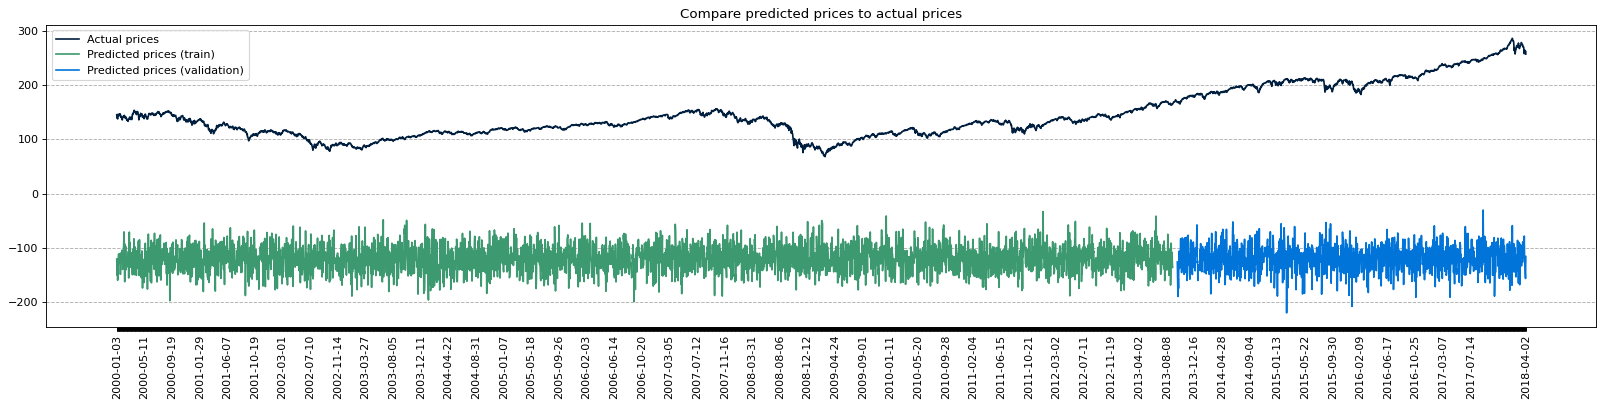

['2013-09-23' '2013-09-24' '2013-09-25' ... '2018-04-13' '2018-04-16'
 '2018-04-17']


/var/folders/dc/7_b1knps4nxcqls_rqxymh2w0000gn/T/ipykernel_23412/419821425.py:95: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None, which='major', axis='y', linestyle='--')


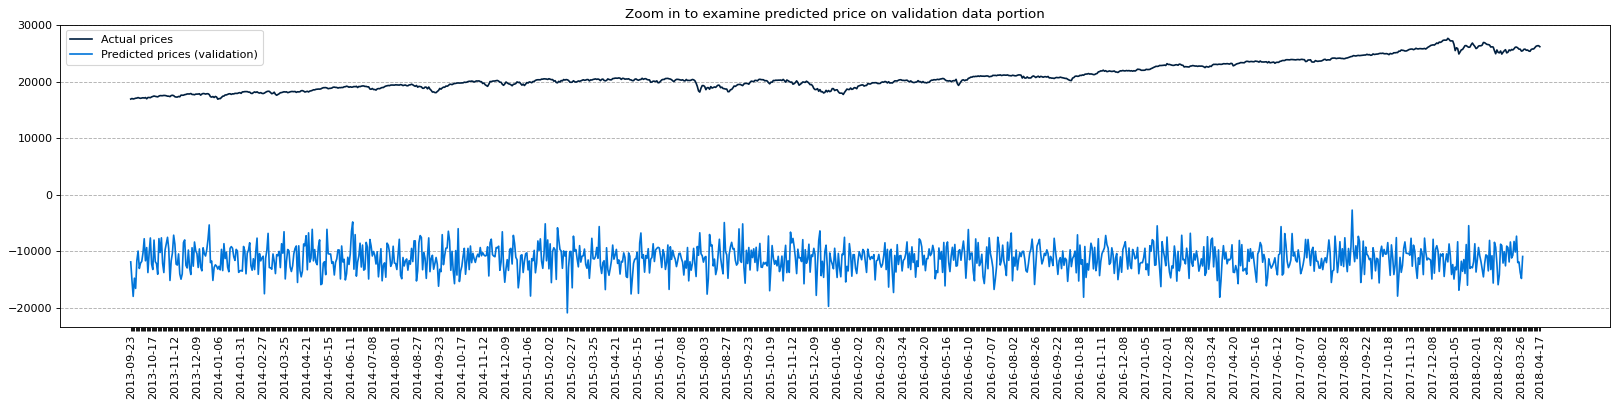

In [757]:
num_data_points = len(data_x_train) + len(data_x_val)

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
xticks_interval =  90
color_actual = "#001f3f"
color_train = "#3D9970"
color_val = "#0074D9"
color_pred_train= "#3D9970"
color_pred_val = "#0074D9"
color_pred_test = "#FF4136"


model.train()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])
l = 0
optimizer.zero_grad()
for idx, (src, trg, trg_y) in enumerate(train_dataloader):
    
    if len(src) == 16:
        output = model(
            src=src.reshape(16, 20, 1), 
            tgt=trg,
            src_mask=src_mask,
            tgt_mask=tgt_mask
            )
            
        out = output.cpu().detach().numpy().squeeze()
        predicted_train = np.concatenate((predicted_train, out))

    else:
        l += len(src)

# predict on the validation data, to see how the model does

predicted_val = np.array([])


for idx, (src, trg, trg_y) in enumerate(val_dataloader):

    if len(src) == 16:
        output = model(
            src=src.reshape(16, 20, 1), 
            tgt=trg,
            src_mask=src_mask,
            tgt_mask=tgt_mask
            )
        out = output.cpu().detach().numpy().squeeze()
        predicted_val = np.concatenate((predicted_val, out))
optimizer.zero_grad()

num_data_points -= l
to_plot_data_y_train_pred = np.zeros(num_data_points)
to_plot_data_y_val_pred = np.zeros(num_data_points)
to_plot_data_y_train_pred[:split_index - l] = predicted_train#transformer.inverseNormalize(predicted_train)
to_plot_data_y_val_pred[split_index+3:] = predicted_val#transformer.inverseNormalize(predicted_val)

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(dataDate[:num_data_points], dataLP[:num_data_points], label="Actual prices", color=color_actual)
plt.plot(dataDate[:num_data_points], to_plot_data_y_train_pred, label="Predicted prices (train)", color=color_pred_train)
plt.plot(dataDate[:num_data_points], to_plot_data_y_val_pred, label="Predicted prices (validation)", color=color_pred_val)
plt.title("Compare predicted prices to actual prices")
xticks = [dataDate[i] if ((i%xticks_interval==0 and (num_data_points-i) > xticks_interval) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

# prepare data for plotting, zoom in validation

to_plot_data_y_val_subset = transformer.inverseNormalize(data_y_val)
to_plot_predicted_val = transformer.inverseNormalize(predicted_val)
to_plot_data_date = dataDate[split_index:num_data_points+l]

print(to_plot_data_date)
# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=color_actual)
plt.plot(to_plot_data_date[:num_data_points-split_index-3], to_plot_predicted_val, label="Predicted prices (validation)", color=color_pred_val)
plt.title("Zoom in to examine predicted price on validation data portion")
xticks = [to_plot_data_date[i] if ((i%int(xticks_interval/5)==0 and (len(to_plot_data_date)-i) > xticks_interval/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
xs = np.arange(0,len(xticks))
plt.xticks(xs, xticks, rotation='vertical')
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()
